In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

from MPyDATA import Factories, VectorField, ScalarField
from MPyDATA import Options
from MPyDATA.arakawa_c.discretisation import from_pdf_2d
from MPyDATA import PeriodicBoundaryCondition, ConstantBoundaryCondition, ExtrapolatedBoundaryCondition
from MPyDATA import Stepper, Solver
from MPyDATA.arakawa_c.traversals import Traversals

In [2]:
options = {
    'upwind': Options(n_iters=-1),
    '2+fct': Options(n_iters=2, flux_corrected_transport=True),
    '3+fct+tot': Options(n_iters=3, flux_corrected_transport=True, third_order_terms=True),
    '2+fct+iga': Options(n_iters=2, flux_corrected_transport=True, infinite_gauge=True)
}

In [3]:
option = options['2+fct']

In [4]:
nlon = 129
nlat = 64
nt = 5120
pi = np.pi
dlmb = 2 * pi / (nlon-1)
dphi = pi / nlat

r = 7 * dlmb
x0 = 3 * pi / 2
y0 = 0

udt = 2 * pi / nt
b = -pi / 2
h0 = 1

In [5]:
@numba.njit()
def pdf(x, y):
    tmp = 2*(
        (np.cos(dphi * (y + 0.5) - pi / 2) * np.sin((dlmb * x - x0) / 2))**2 +
        np.sin((dphi * (y + 0.5) - pi / 2 - y0) / 2)**2
    )
    return h0 + np.where(
        # if
        tmp - r**2 <= 0,
        # then
        1 - np.sqrt(tmp)/r,
        # else
        0.
    )

In [6]:
x, y, z = from_pdf_2d(pdf, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))
# yrange is (0, nlat) because in pdf we subtract pi/2, so domain is (-pi/2, pi/2)

In [7]:
z.shape

(129, 64)

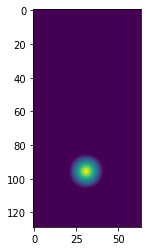

In [8]:
plt.imshow(z)

In [9]:
def ad_x(i, j):
    return dlmb * udt * (
        np.cos(b) * np.cos((j+0.5) * dphi - pi / 2) + 
        np.sin(b) * np.sin((j+0.5) * dphi - pi / 2) * np.cos((i+0.5) * dlmb)
    )


In [10]:
def ad_y(i, j):
    return -dlmb * udt * np.sin(b) * np.sin((i) * dlmb)* np.cos((j+1) * dphi - pi / 2)

In [11]:
advector_x = np.array([[
    ad_x(i, j)
    for i in range(nlat)] for j in range(nlon+1)])

advector_y = np.array([[
    ad_y(i,j)
    for i in range(nlat+1)] for j in range(nlon)])

(130, 64)


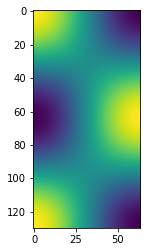

In [12]:
plt.imshow(advector_x)
print(advector_x.shape)

(129, 65)


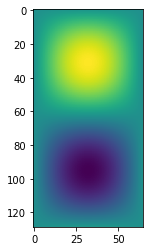

In [13]:
plt.imshow(advector_y)
print(advector_y.shape)

In [14]:
print(np.max(advector_x))

6.020300424633783e-05


## Defining scale (if g_factor is not used values of advectors are too small)

In [15]:
sc = 10000
#sc=1

In [16]:
import numba

    
class PolarBoundaryCondition:
    def __init__(self, grid, longitude_idx, latitude_idx):
        self.nlon = grid[longitude_idx]
        self.nlat = grid[latitude_idx]
        assert self.nlon % 2 == 1

        self.nlon_half = self.nlon // 2 + 1
        self.lon_idx = longitude_idx
        self.lat_idx = latitude_idx

    def make_scalar(self, at, halo):
        nlon_half = self.nlon_half
        nlat = self.nlat
        lon_idx = self.lon_idx
        lat_idx = self.lat_idx
        self.halo = halo
        left_edge_idx = halo-1
        right_edge_idx = nlat+halo
        
    
        @numba.njit()
        def fill_halos(psi, n, sign):
            lon = psi[0][lon_idx]
            lat = psi[0][lat_idx]
            if lat<=left_edge_idx:
                step = (left_edge_idx-lat)*2+1
            if lat>=right_edge_idx:
                step = (lat-right_edge_idx)*2+1
                
            #print(psi[0], step)
            
            return at(*psi, sign*step, nlon_half * (-1 if lon > nlon_half else 1))  # TODO: sign will not work for halo>2
        return fill_halos

    def make_vector(self, at):
        @numba.njit()
        def fill_halos(_, __, ___):
            raise NotImplementedError()
        return fill_halos

In [17]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + 0.5) - pi / 2)
x, y, g_factor_z = from_pdf_2d(pdf_g_factor, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))

In [18]:
g_factor = ScalarField(g_factor_z, halo=option.n_halo, boundary_conditions=(PeriodicBoundaryCondition(), PolarBoundaryCondition(g_factor_z.shape, 0,1)))

In [19]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + 0.5) - pi / 2)

In [20]:
x, y, z = from_pdf_2d(pdf, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))
advector = VectorField(
    data=(advector_x*sc, advector_y*sc),
    halo=option.n_halo,
    boundary_conditions=(PeriodicBoundaryCondition(),ConstantBoundaryCondition(0))    
)
advectee = ScalarField(z, halo=option.n_halo, boundary_conditions=(PeriodicBoundaryCondition(), PolarBoundaryCondition(z.shape, 0,1)))

In [21]:
stepper = Stepper(options=option, n_dims=2, non_unit_g_factor=False)

In [22]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor )


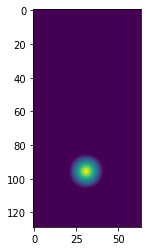

In [23]:
state = solver.curr.get().copy()
plt.imshow(state)

In [24]:

states_history = []
for i in range(60):
    solver.advance(nt=16)
    state = solver.curr.get().copy()
    states_history.append(state)
    

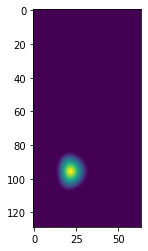

In [25]:
plt.imshow(states_history[0])

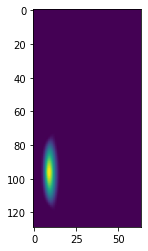

In [26]:
plt.imshow(states_history[2])

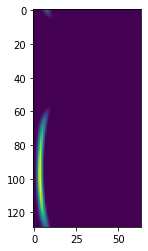

In [27]:
plt.imshow(states_history[4])

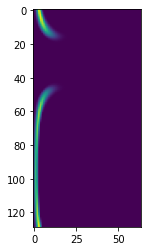

In [28]:
plt.imshow(states_history[6])

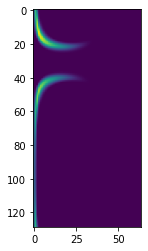

In [29]:
plt.imshow(states_history[8])

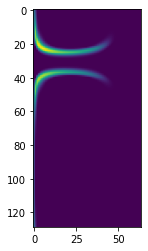

In [30]:
plt.imshow(states_history[10])

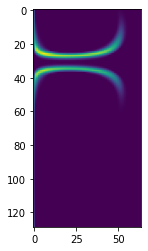

In [31]:
plt.imshow(states_history[12])

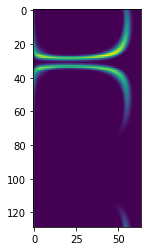

In [32]:
plt.imshow(states_history[14])

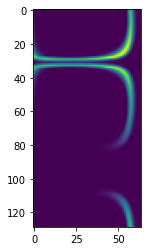

In [33]:
plt.imshow(states_history[16])

# Plots 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


    
def plot_state(state, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.set_axis_off()
    theta = np.linspace(0,np.pi,nlat,endpoint=True)
    phi   = np.linspace(0,np.pi*2,nlon,endpoint=True)

    X = np.outer(np.sin(theta),np.cos(phi))
    Y = np.outer(np.sin(theta),np.sin(phi))
    Z = np.outer(np.cos(theta),np.ones(nlon))

    c = state.transpose().copy()
    c-=1-1e-6

    
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=cm.plasma(c/np.amax(c)), alpha=0.22, linewidth=1)
    m = cm.ScalarMappable(cmap=cm.plasma)
    m.set_array(c)
    plt.colorbar(m)
    if save_path:
        plt.savefig(save_path)
    return plt.show()



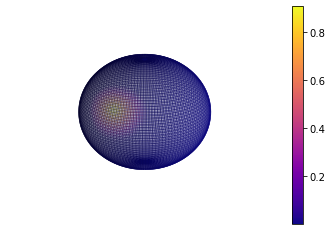

In [35]:
plot_state(states_history[0], 'test.png')

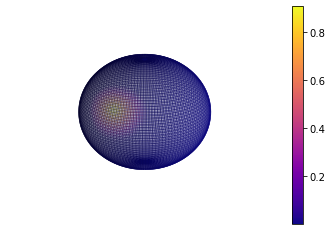

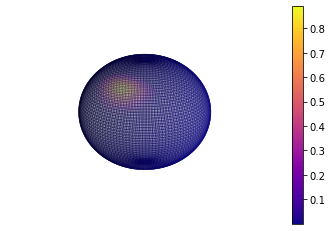

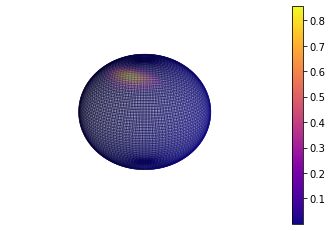

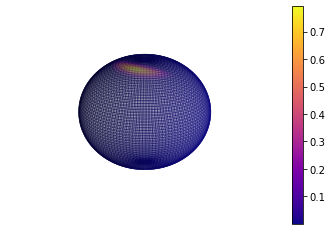

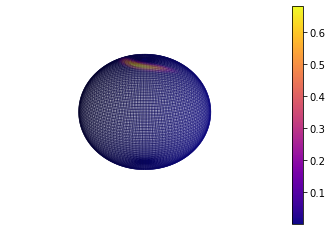

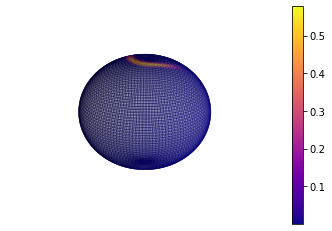

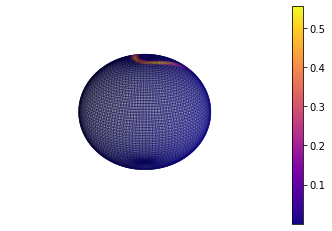

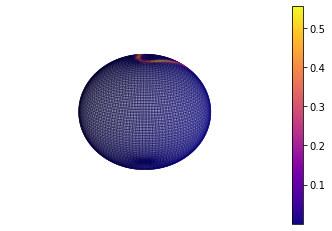

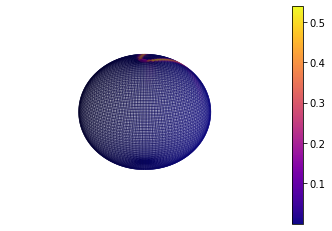

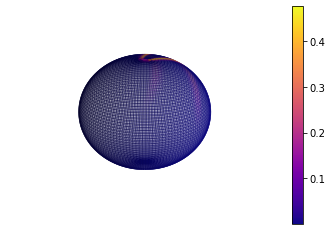

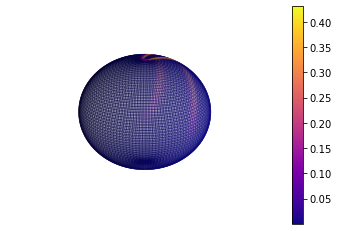

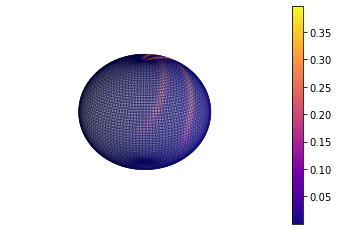

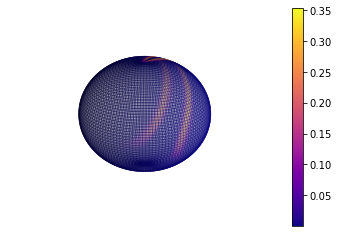

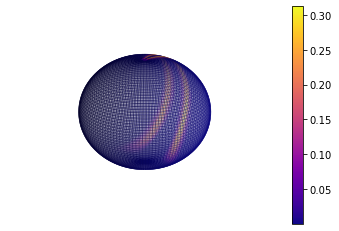

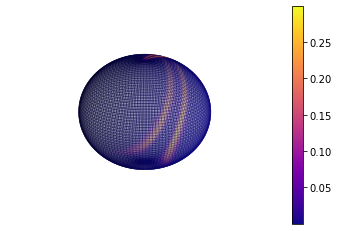

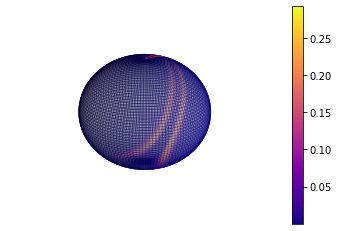

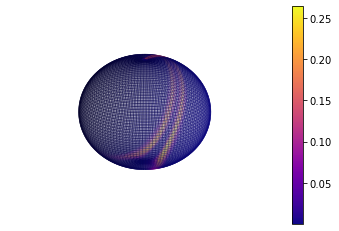

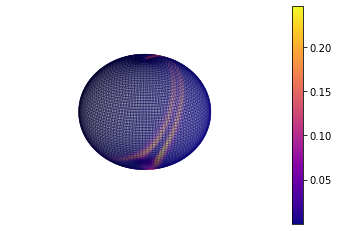

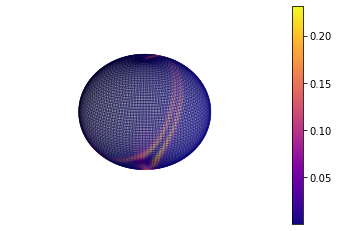

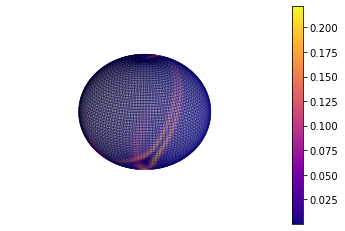

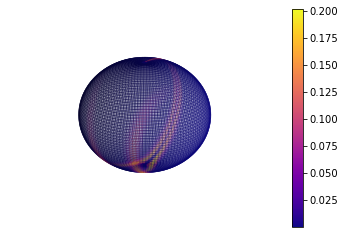

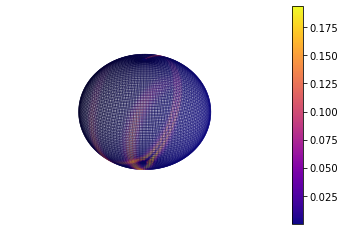

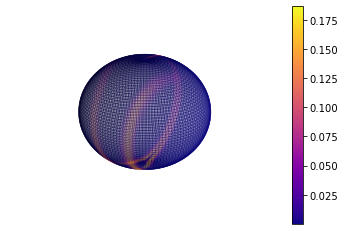

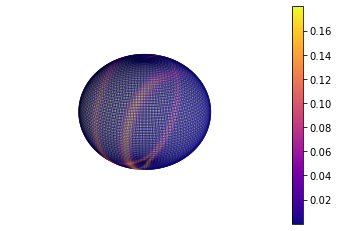

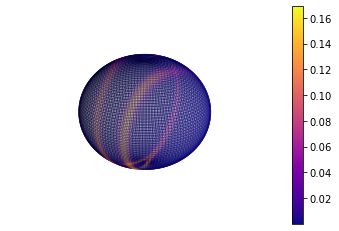

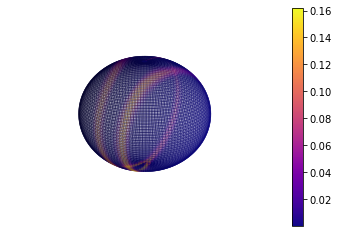

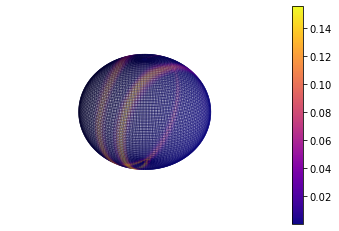

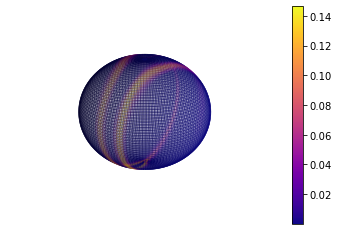

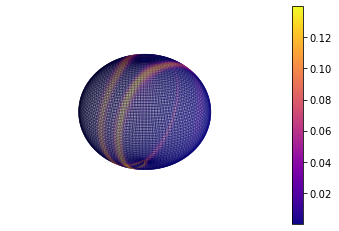

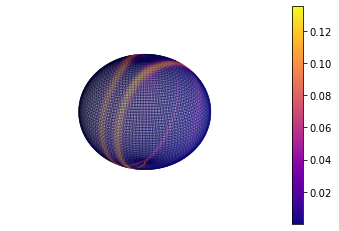

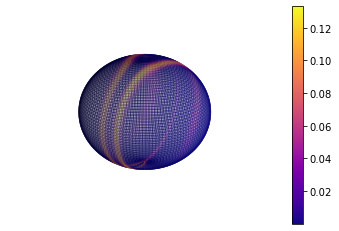

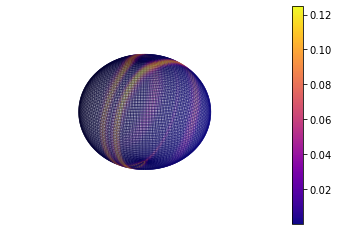

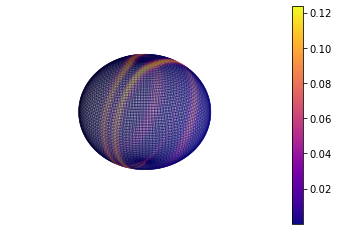

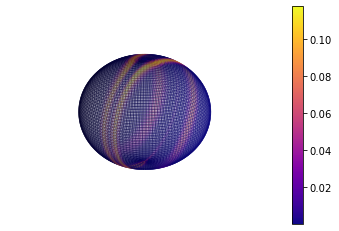

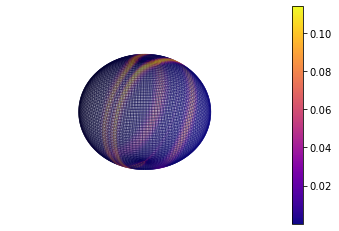

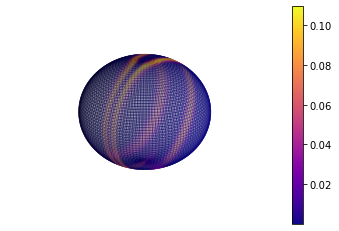

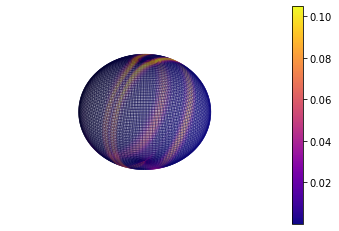

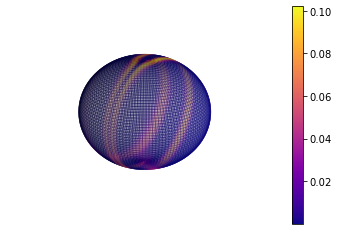

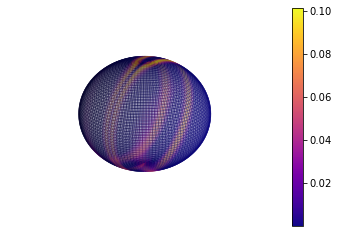

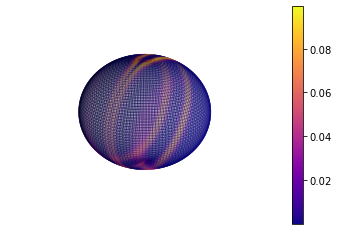

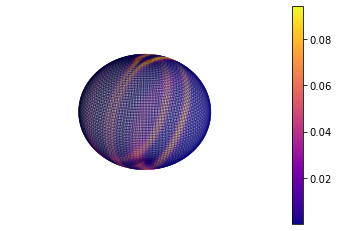

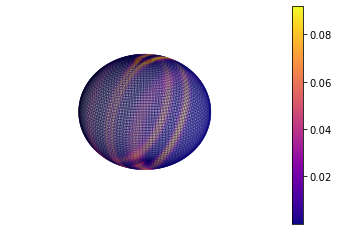

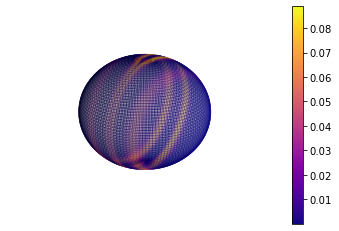

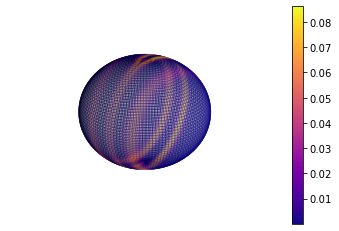

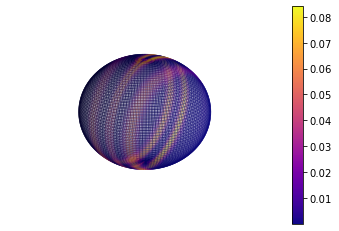

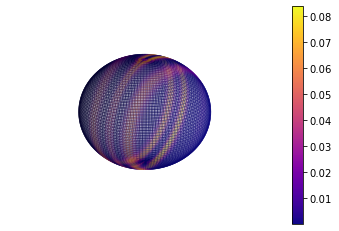

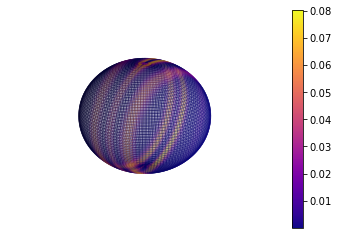

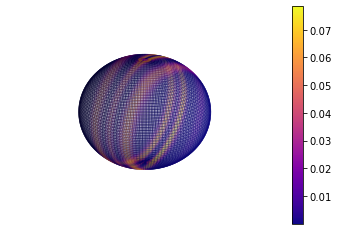

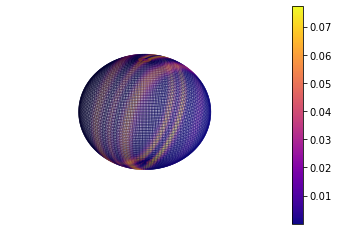

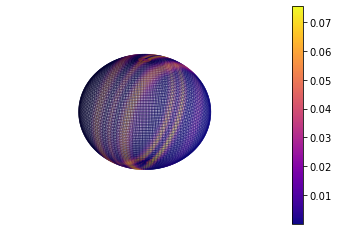

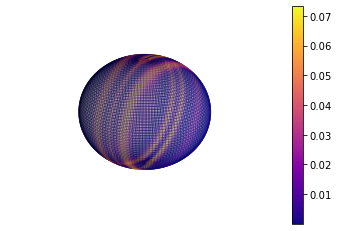

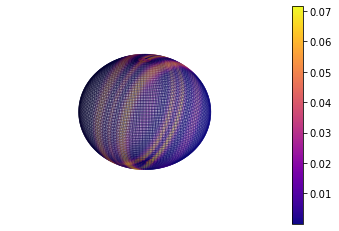

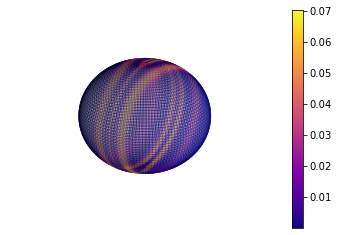

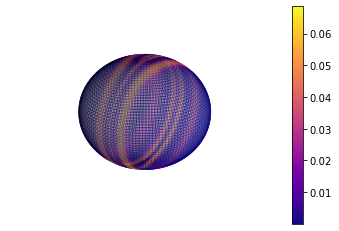

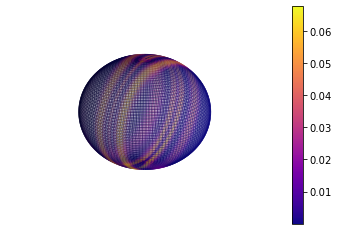

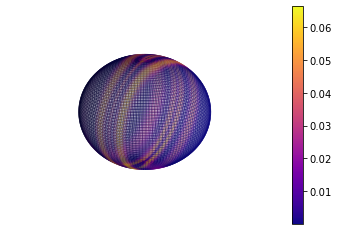

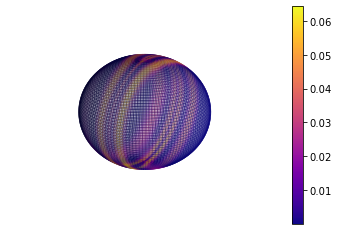

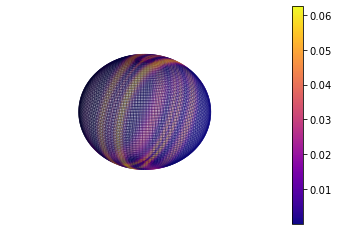

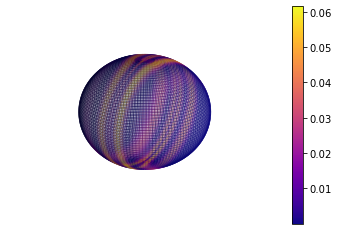

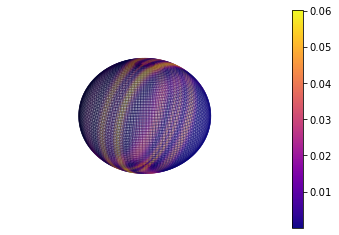

In [36]:
!mkdir animation
paths = []
for i, state in enumerate(states_history):
    path = 'animation/{}.png'.format(i)
    paths.append(path)
    plot_state(state, path)

In [40]:
import os
os.system("ffmpeg -f image2 -r 10 -i ./animation/%01d.png -vcodec mpeg4 -y simulation.mp4")

0

In [41]:
from IPython.display import Video

Video("simulation.mp4")

In [42]:
2

2

# TESTY

In [43]:
class PolarBoundaryCondition:
    def __init__(self, grid, longitude_idx, latitude_idx):
        self.nlon = grid[longitude_idx]
        self.nlat = grid[latitude_idx]
        assert self.nlon % 2 == 1

        self.nlon_half = self.nlon // 2 + 1
        self.lon_idx = longitude_idx
        self.lat_idx = latitude_idx

    def make_scalar(self, at, halo):
        nlon_half = self.nlon_half
        nlat = self.nlat
        lon_idx = self.lon_idx
        lat_idx = self.lat_idx
        self.halo = halo
        left_border_idx = halo-1
        right_border_idx = nlat+halo
        
    
        @numba.njit()
        def fill_halos(psi, n, sign):
            lon = psi[0][lon_idx]
            lat = psi[0][lat_idx]
            if lat<=left_border_idx:
                step = (left_border_idx-lat)*2+1
            if lat>=right_border_idx:
                step = (lat-right_border_idx)*2+1
                
            print(psi[0], step)
            
            return at(*psi, sign*step, nlon_half * (-1 if lon > nlon_half else 1))  # TODO: sign will not work for halo>2
        return fill_halos

    def make_vector(self, at):
        @numba.njit()
        def fill_halos(_, __, ___):
            raise NotImplementedError()
        return fill_halos

In [44]:
data = np.array(
             [
                 [1, 11],
                 [2, 12],
                 [3, 13],
                 [4, 14],
                 [5, 15],
                 [6, 16],
                 [7, 17],
                 [8, 18],
                 [9, 19],
             ]
         )
halo = 2

In [45]:
data.shape

(9, 2)

In [46]:
bc = (
 PeriodicBoundaryCondition(),
 PolarBoundaryCondition(data.shape, 0, 1)
)
field = ScalarField(data, halo, bc)
meta_and_data, fill_halos = field.impl
traversals = Traversals(grid=data.shape, halo=halo, jit_flags={})
sut, _ = traversals.make_boundary_conditions()

# act


In [47]:
sut(*meta_and_data, *fill_halos)

(0, 0) 3
(1, 0) 3
(2, 0) 3
(3, 0) 3
(4, 0) 3
(5, 0) 3
(6, 0) 3
(7, 0) 3
(8, 0) 3
(9, 0) 3
(10, 0) 3
(11, 0) 3
(12, 0) 3
(0, 1) 1
(1, 1) 1
(2, 1) 1
(3, 1) 1
(4, 1) 1
(5, 1) 1
(6, 1) 1
(7, 1) 1
(8, 1) 1
(9, 1) 1
(10, 1) 1
(11, 1) 1
(12, 1) 1
(0, 4) 1
(1, 4) 1
(2, 4) 1
(3, 4) 1
(4, 4) 1
(5, 4) 1
(6, 4) 1
(7, 4) 1
(8, 4) 1
(9, 4) 1
(10, 4) 1
(11, 4) 1
(12, 4) 1
(0, 5) 3
(1, 5) 3
(2, 5) 3
(3, 5) 3
(4, 5) 3
(5, 5) 3
(6, 5) 3
(7, 5) 3
(8, 5) 3
(9, 5) 3
(10, 5) 3
(11, 5) 3
(12, 5) 3


In [48]:
meta_and_data[1]

array([[14.,  4.,  8., 18., 14.,  4.],
       [15.,  5.,  9., 19., 15.,  5.],
       [16.,  6.,  1., 11., 16.,  6.],
       [17.,  7.,  2., 12., 17.,  7.],
       [18.,  8.,  3., 13., 18.,  8.],
       [19.,  9.,  4., 14., 19.,  9.],
       [19.,  9.,  5., 15., 19.,  9.],
       [11.,  1.,  6., 16., 11.,  1.],
       [12.,  2.,  7., 17., 12.,  2.],
       [13.,  3.,  8., 18., 13.,  3.],
       [14.,  4.,  9., 19., 14.,  4.],
       [15.,  5.,  1., 11., 15.,  5.],
       [16.,  6.,  2., 12., 16.,  6.]])

In [49]:
data.shape

(9, 2)